# Covariogram
Used to create the covariograms presented in the paper.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import stif
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numba as nb

In [2]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "rmfamily"
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

## Prepare data

In [3]:
df = pd.read_feather('data/combined_synthetic1.feather')

In [4]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)).set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=32644)
gdf['x'] = gdf.geometry.x / 1000
gdf['y'] = gdf.geometry.y / 1000

In [5]:
variables = [
    "temperature",
    "relative_humidity",
    "solar_radiation",
    "total_evaporation_sum",
    "wind_speed",
    "surface_pressure",
    "precipitation",
    "leaf_area_index_high_vegetation",
    "leaf_area_index_low_vegetation",
]

suffixes = [] #[""]

for lag_i in range(1, 30):
    suffixes.append(f"_l{lag_i}")

vars = []
for var in variables:
    for suffix in suffixes:
        vars.append(var+suffix)

In [6]:
gdf["id"] = gdf.index

In [7]:
vars_with_id = vars + ["id", "presence", "date", "x", "y"]

In [8]:
XY_long = pd.wide_to_long(gdf[vars_with_id], stubnames=variables, i=["id"], j="var", suffix=r"_l\d+")

In [9]:
XY_average = XY_long.groupby("id").mean()

In [10]:
gdf2 = XY_average

## Covariogram calculation

adapted from STIF package

In [11]:
@nb.njit(fastmath=True)
def calc_distance_matrix_1d(vec):
    res = np.empty((len(vec), len(vec)), dtype=vec.dtype)
    for i in range(len(vec)):
        for j in range(len(vec)):
            res[i, j] = np.abs(vec[i]-vec[j])
    return res


@nb.njit(fastmath=True)
def calc_distance_matrix_2d(vec):
    res = np.empty((vec.shape[0], vec.shape[0]), dtype=vec.dtype)
    for i in range(vec.shape[0]):
        for j in range(vec.shape[0]):
            res[i, j] = np.sqrt(
                (vec[i, 0]-vec[j, 0])**2 +
                (vec[i, 1]-vec[j, 1])**2,
            )
    return res


@nb.njit(fastmath=True)
def cosine_distance(x, y):
    return (1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))) / 2


@nb.njit(fastmath=True)
def calc_distance_matrix_cosine(vec):
    res = np.empty((vec.shape[0], vec.shape[0]), dtype=vec.dtype)
    for i in range(vec.shape[0]):
        for j in range(vec.shape[0]):
            res[i, j] = cosine_distance(vec[i, :], vec[j, :])
    return res


@nb.njit(fastmath=True)
def pair_index_generator(n, n_samples=None):
    if n_samples is None:
        for i in range(n):
            for j in range(i+1, n):
                yield i, j
    else:
        for _ in range(n_samples):
            i = np.random.randint(n)
            j = np.random.randint(n)

            if i == j:
                continue

            yield i, j

# adapted from the variogram in STIF
@nb.njit(fastmath=True)
def get_correlogram(
    features,
    time,
    val,
    space_dist_max,
    time_dist_max,
    n_space_bins,
    n_time_bins,
    n_samples,
    distance,
):
    n = len(val)

    mean = np.mean(val)
    var = np.var(val)

    # prepare histogram
    space_bin_width = space_dist_max / n_space_bins
    time_bin_width = time_dist_max / n_time_bins
    hist = np.zeros((n_space_bins, n_time_bins), dtype=np.float64)
    norm = np.zeros((n_space_bins, n_time_bins), dtype=np.float64)

    for i, j in pair_index_generator(n, n_samples):
        if distance == "euclidean":
            features_lag = np.sqrt(
                np.square(features[i, 0]-features[j, 0]) +
                np.square(features[i, 1]-features[j, 1]),
            )
        elif distance == "cosine":
            features_lag = cosine_distance(features[i, :], features[j, :])

        if features_lag > space_dist_max:
            continue
        time_lag = np.abs(time[i]-time[j])
        if time_lag > time_dist_max:
            continue
        sq_val_delta = (val[i]-mean)*(val[j]-mean)

        # space_lag, time_lag, sq_val_delta
        space_bin = int(features_lag / space_bin_width)
        time_bin = int(time_lag / time_bin_width)

        if 0 <= space_bin < n_space_bins and\
                0 <= time_bin < n_time_bins:
            hist[space_bin, time_bin] += sq_val_delta
            norm[space_bin, time_bin] += 1

    # I think this "/2" is necessary, because in samples_per_bin are only
    # n^2/2 samples in total
    correlogram = np.divide(
        hist,
        norm,
        # out=np.ones_like(hist) * np.nan,
        # where=norm != 0,
    ) / var

    for i in range(n_space_bins):
        for j in range(n_time_bins):
            if norm[i, j] == 0:
                correlogram[i, j] = np.nan

    return correlogram, norm, space_bin_width, time_bin_width

In [12]:
# adapted from the variogram in STIF
def calc_empirical_correlogram(
        self,
        idxs=slice(None),
        space_dist_max=3,
        time_dist_max=10,
        n_space_bins=10,
        n_time_bins=10,
        el_max=None,
        distance="euclidean",
    ):
        time_coords = self._data.time_coords[idxs]
        residuals = self._residuals[idxs]

        correlogram, samples_per_bin, bin_width_space, bin_width_time =\
            get_correlogram(
                self._data.space_coords[idxs, :],
                time_coords,
                residuals,
                space_dist_max,
                time_dist_max,
                n_space_bins,
                n_time_bins,
                el_max,
                distance,
            )

        bins_space = np.arange(n_space_bins+1) * bin_width_space
        bins_space = ((bins_space[:-1] + bins_space[1:])/2)

        bins_time = np.arange(n_time_bins+1) * bin_width_time
        bins_time = ((bins_time[:-1] + bins_time[1:])/2)

        self._variogram = correlogram
        self._distance = distance
        self._variogram_bins_space = bins_space
        self._variogram_bins_time = bins_time
        self._variogram_samples_per_bin = samples_per_bin

## Create covariogram on raw observation data

In [13]:
d0 = stif.Data(gdf2, space_cols=["x", "y"], time_col="date", predictand_col="presence", covariate_cols=["x", "y", "date"],)

In [14]:
class AlwaysZeroClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # This classifier does not need fitting, so we just pass
        return self

    def predict(self, X):
        # Always predict 0 regardless of the input
        return np.zeros(X.shape[0], dtype=int)

    def predict_proba(self, X):
        # Return a probability distribution where class 0 has probability 1
        return np.ones((X.shape[0], 1))

In [15]:
covariate_model0 = AlwaysZeroClassifier()
predictor0 = stif.Predictor(d0, covariate_model0)
predictor0.fit_covariate_model()

In [16]:
predictor0._prepare_geostatistics()

In [ ]:
calc_empirical_correlogram(
    predictor-1,
    space_dist_max=11,
    time_dist_max=119,
    n_space_bins=5,
    n_time_bins=5,
    el_max=1e9,
)

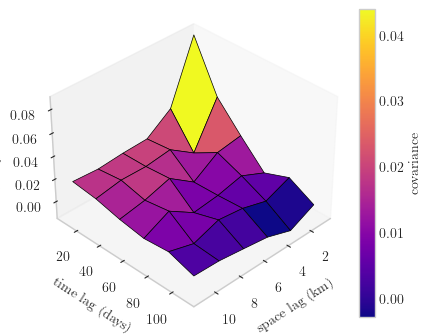

In [ ]:
fig = plt.figure(figsize=(5, 4))
ax = plt.axes(projection='3d')

predictor0.plot_empirical_variogram(
    fig=fig,
    ax=ax,
    vrange=(None, None),
    title="",
)

ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])


ax.set_xlabel(r"space lag (km)")
ax.set_ylabel("time lag (days)")
ax.set_zlabel('covariance')

cbar = ax.collections[-1].colorbar
cbar.set_label('covariance')

In [ ]:
np.max(predictor0._variogram)

0.08877554141471738

## Create the covariogram on regression residuals

In [ ]:
columns = list(gdf.columns)

In [ ]:
# items to be removed
unwanted = {'level_0',
 'dnn_peat_id',
 'dnn_variety',
 'cell_id',
 'latitude',
 'longitude',
 'presence',
 'geometry',
}

covars = [el for el in columns if el not in unwanted]

In [ ]:
gdf.presence = gdf.presence.astype(bool)
gdf2.presence = gdf2.presence.astype(bool)

In [ ]:
d1 = stif.Data(gdf2, space_cols=["x", "y"], time_col="date", predictand_col="presence", covariate_cols=variables)

In [ ]:
covariate_model1 = MLPClassifier(
    hidden_layer_sizes=(5, 3),
    activation='relu',
    solver='adam',
    max_iter=500,
    verbose=1,
    learning_rate="constant",
    learning_rate_init=0.001,
    )
predictor1 = stif.Predictor(d1, covariate_model1, cv_splits=3)

In [ ]:
predictor1.calc_cross_validation()

Iteration 1, loss = 0.34653654
Iteration 2, loss = 0.22371951
Iteration 3, loss = 0.12116689
Iteration 4, loss = 0.09807236
Iteration 5, loss = 0.09598742
Iteration 6, loss = 0.09569628
Iteration 7, loss = 0.09553985
Iteration 8, loss = 0.09539467
Iteration 9, loss = 0.09525628
Iteration 10, loss = 0.09506941
Iteration 11, loss = 0.09489359
Iteration 12, loss = 0.09472516
Iteration 13, loss = 0.09453591
Iteration 14, loss = 0.09434749
Iteration 15, loss = 0.09415860
Iteration 16, loss = 0.09395291
Iteration 17, loss = 0.09373958
Iteration 18, loss = 0.09350210
Iteration 19, loss = 0.09328352
Iteration 20, loss = 0.09305234
Iteration 21, loss = 0.09281292
Iteration 22, loss = 0.09260646
Iteration 23, loss = 0.09233059
Iteration 24, loss = 0.09211081
Iteration 25, loss = 0.09185309
Iteration 26, loss = 0.09166076
Iteration 27, loss = 0.09150460
Iteration 28, loss = 0.09128472
Iteration 29, loss = 0.09100144
Iteration 30, loss = 0.09074967
Iteration 31, loss = 0.09075998
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Iteration 1, loss = 0.20238207
Iteration 2, loss = 0.08902080
Iteration 3, loss = 0.08794517
Iteration 4, loss = 0.08685534
Iteration 5, loss = 0.08597101
Iteration 6, loss = 0.08540453
Iteration 7, loss = 0.08486983
Iteration 8, loss = 0.08444233
Iteration 9, loss = 0.08404769
Iteration 10, loss = 0.08380712
Iteration 11, loss = 0.08358262
Iteration 12, loss = 0.08341213
Iteration 13, loss = 0.08327900
Iteration 14, loss = 0.08301612
Iteration 15, loss = 0.08301156
Iteration 16, loss = 0.08295031
Iteration 17, loss = 0.08280882
Iteration 18, loss = 0.08283925
Iteration 19, loss = 0.08263945
Iteration 20, loss = 0.08260233
Iteration 21, loss = 0.08258811
Iteration 22, loss = 0.08249201
Iteration 23, loss = 0.08235759
Iteration 24, loss = 0.08246978
Iteration 25, loss = 0.08227135
Iteration 26, loss = 0.08226771
Iteration 27, loss = 0.08220794
Iteration 28, loss = 0.08223709
Iteration 29, loss = 0.08212601
Iteration 30, loss = 0.08210935
Iteration 31, loss = 0.08198084
Iteration 32, los

In [ ]:
predictor1._cov_model.predict_proba(predictor1._X)

array([[9.82873891e-01, 1.71261093e-02],
       [9.99168200e-01, 8.31799741e-04],
       [9.89371261e-01, 1.06287394e-02],
       ...,
       [9.74413551e-01, 2.55864488e-02],
       [9.38598634e-01, 6.14013662e-02],
       [9.13056919e-01, 8.69430808e-02]])

In [ ]:
print(predictor1._is_binary)
print(predictor1._is_keras_model)

True
False


In [ ]:
#predictor1.get_covariate_probability()

Show ROC.. probably slightly overfitting

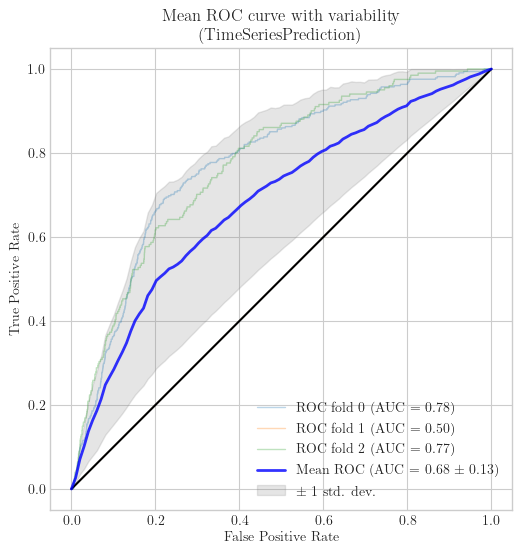

In [ ]:
predictor1.plot_cross_validation_roc()

In [ ]:
predictor1.fit_covariate_model()

Iteration 1, loss = 0.19264843
Iteration 2, loss = 0.08689644
Iteration 3, loss = 0.08251720
Iteration 4, loss = 0.08065776
Iteration 5, loss = 0.07953864
Iteration 6, loss = 0.07893602
Iteration 7, loss = 0.07860406
Iteration 8, loss = 0.07825580
Iteration 9, loss = 0.07796832
Iteration 10, loss = 0.07778467
Iteration 11, loss = 0.07760824
Iteration 12, loss = 0.07751172
Iteration 13, loss = 0.07738995
Iteration 14, loss = 0.07731040
Iteration 15, loss = 0.07720020
Iteration 16, loss = 0.07721041
Iteration 17, loss = 0.07713514
Iteration 18, loss = 0.07705603
Iteration 19, loss = 0.07698412
Iteration 20, loss = 0.07700265
Iteration 21, loss = 0.07693694
Iteration 22, loss = 0.07686729
Iteration 23, loss = 0.07681861
Iteration 24, loss = 0.07680122
Iteration 25, loss = 0.07678356
Iteration 26, loss = 0.07673599
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [ ]:
predictor1._prepare_geostatistics()

In [ ]:
calc_empirical_correlogram(
    predictor1,
    space_dist_max=12,
    time_dist_max=120,
    n_space_bins=6,
    n_time_bins=6,
    el_max=2e9,
)

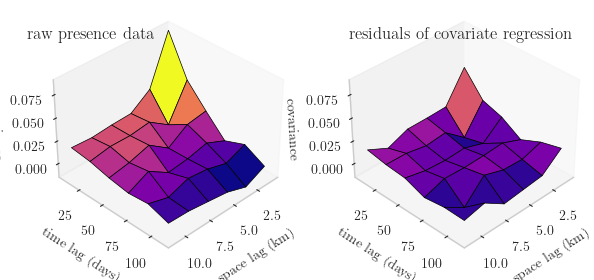

In [ ]:
fig = plt.figure(figsize=(7, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

vmax = 0.035

predictor0.plot_empirical_variogram(
    fig=fig,
    ax=ax1,
    vrange=(0, vmax),
)
ax1.set_title("raw presence data", y=1.0, pad=-7, x=0.2)


ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.set_ylim(ax1.get_ylim()[::-1])


ax1.set_xlabel(r"space lag (km)")
ax1.set_ylabel("time lag (days)")
ax1.set_zlabel('covariance')

cbar = ax1.collections[-1].colorbar
cbar.remove()


predictor1.plot_empirical_variogram(
    fig=fig,
    ax=ax2,
    vrange=(0, vmax),
    title="residuals of covariate regression",
)

ax2.set_title("residuals of covariate regression", y=1.0, pad=-7)
ax2.set_xlim(ax2.get_xlim()[::-1])
ax2.set_ylim(ax2.get_ylim()[::-1])

ax2.set_zlim(ax1.get_zlim())



ax2.set_xlabel(r"space lag (km)")
ax2.set_ylabel("time lag (days)")
ax2.set_zlabel('covariance')

cbar = ax2.collections[-1].colorbar
cbar.set_label('covariance')
cbar.remove()


In [ ]:
np.max(predictor1._variogram)

0.04818724316311515

In [ ]:
np.max(predictor0._variogram)

0.08877554141471738